### Import libraries and sub-libraries

In [205]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
import math
import random
import traceback
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

### Font setting

In [206]:
try:
    from fontsetting import font_cmu
    plt = font_cmu(plt)
except ImportError:
    print("Custom font setting 'fontsetting.py' not found. Using default fonts.")
    pass

### Configuration & Hyperparameters

In [ ]:
# Data Paths
TRAIN_HIGH_RES_DIR = 'data/train/high-res'
TRAIN_LOW_RES_DIR = 'data/train/low-res'
VAL_HIGH_RES_DIR = 'data/val/high-res'
VAL_LOW_RES_DIR = 'data/val/low-res'

# Model Saving Paths
SR_MODEL_SAVE_PATH = 'best_sr_upsampler_model.pth' # Path for Stage 1 model
REFINE_MODEL_SAVE_PATH = 'best_refinement_unet_model.pth' # Path for Stage 2 model

# Training Settings
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 8
LEARNING_RATE_SR = 1e-4 # Learning rate for Stage 1 (EDSR)
LEARNING_RATE_REFINE = 1e-4 # Learning rate for Stage 2 (UNet)
NUM_EPOCHS_SR = 100 # Epochs for Stage 1 training
NUM_EPOCHS_REFINE = 100 # Epochs for Stage 2 training
LOSS_ALPHA = 0.85 # Weight for (1-SSIM) loss (used in both stages)

# --- Model Specific ---
# EDSR Upsampler settings
EDSR_N_RESBLOCKS = 16
EDSR_N_FEATS = 64
EDSR_RES_SCALE = 0.1

# UNet Refiner settings
UNET_DEPTH = 3
UNET_START_FILTERS = 64

# --- LR Scheduler Settings ---
# Using separate schedulers might be beneficial, but start with same settings
SCHEDULER_FACTOR = 0.1
SCHEDULER_PATIENCE = 10
SCHEDULER_THRESHOLD = 1e-4
SCHEDULER_MIN_LR = 1e-7

# --- Experiment Tracking ---
# Use different subdirs for stages? Or one for the whole process?
TENSORBOARD_LOG_DIR_SR = "runs/staged_edsr_unet/stage1_sr"
TENSORBOARD_LOG_DIR_REFINE = "runs/staged_edsr_unet/stage2_refine"

# --- Reproducibility ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # May add these for further determinism, but can impact performance
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False

print(f'Device available: {DEVICE}')
print(f'Batch Size: {BATCH_SIZE}')
print(f'Initial Learning Rate: {LEARNING_RATE}')
print(f'Number of Epochs: {NUM_EPOCHS}')
print(f'Loss Alpha (Weight for 1-SSIM): {LOSS_ALPHA}')
print(f'Loss Beta (Weight for Pixel Loss): {1-LOSS_ALPHA}') # Calculated beta
print(f"UNet Depth: {UNET_DEPTH}")
print(f"UNet Start Filters: {UNET_START_FILTERS}")
print(f"TensorBoard Log Directory: {TENSORBOARD_LOG_DIR}")

Device available: cuda
Batch Size: 8
Initial Learning Rate: 0.0001
Number of Epochs: 150
Loss Alpha (Weight for 1-SSIM): 0.85
Loss Beta (Weight for Pixel Loss): 0.15000000000000002
UNet Depth: 3
UNet Start Filters: 64
TensorBoard Log Directory: runs/unet_sr_experiment


### Data Loading and Transformations

In [208]:
class TIFFDataset(Dataset):
    def __init__(self, high_res_dir, low_res_dir, mode='train'):
        self.high_res_dir = high_res_dir
        self.low_res_dir = low_res_dir
        self.mode = mode # Store the mode (train/val)

        # Validate mode
        if self.mode not in ['train', 'val']:
            raise ValueError("Mode must be 'train' or 'val'")

        try:
            self.high_res_filenames = sorted([f for f in os.listdir(high_res_dir) if f.endswith('.tif')])
            self.low_res_filenames = sorted([f for f in os.listdir(low_res_dir) if f.endswith('.tif')])
        except FileNotFoundError as e:
            print(f"Error: Directory not found - {e}. Please check data paths.")
            raise

        if len(self.high_res_filenames) != len(self.low_res_filenames):
            raise ValueError("Mismatch in number of high-res and low-res files.")
        if not all(hr.replace('high','').replace('low','') == lr.replace('high','').replace('low','') for hr, lr in zip(self.high_res_filenames, self.low_res_filenames)):
             print("Warning: File names in high-res and low-res directories do not perfectly match (ignoring 'high'/'low' prefix). Assuming correspondence by sorted order.")

        self.filenames = self.high_res_filenames # Use high-res list as reference

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        high_res_filename = self.filenames[idx]
        low_res_filename = self.low_res_filenames[idx]

        high_res_path = os.path.join(self.high_res_dir, high_res_filename)
        low_res_path = os.path.join(self.low_res_dir, low_res_filename)

        try:
            # 1. Load images using PIL (WITHOUT .convert('L'))
            high_res_img_pil = Image.open(high_res_path)
            low_res_img_pil = Image.open(low_res_path)

            # 2. Check sizes (Resizing should handle mode 'F' correctly)
            target_high_res_size = (256, 256) # H, W
            target_low_res_size = (128, 128) # H, W
            if high_res_img_pil.size != target_high_res_size[::-1]:
                 high_res_img_pil = high_res_img_pil.resize(target_high_res_size[::-1], Image.BICUBIC)
            if low_res_img_pil.size != target_low_res_size[::-1]:
                 low_res_img_pil = low_res_img_pil.resize(target_low_res_size[::-1], Image.BICUBIC)

            # 3. Convert PIL images to Tensors
            # TF.to_tensor handles mode 'F' directly (no scaling)
            # and other modes like 'L' (scales 0-255 to 0-1)
            # Add check: if not mode F, convert to L first (safer fallback)
            if high_res_img_pil.mode != 'F':
                 high_res_img_pil = high_res_img_pil.convert('L')
            if low_res_img_pil.mode != 'F':
                 low_res_img_pil = low_res_img_pil.convert('L')

            low_res_tensor = TF.to_tensor(low_res_img_pil)
            high_res_tensor = TF.to_tensor(high_res_img_pil)

            # 4. Apply Geometric Augmentations ONLY if mode is 'train'
            if self.mode == 'train':
                # Random Horizontal Flip
                if random.random() < 0.5:
                    low_res_tensor = TF.hflip(low_res_tensor)
                    high_res_tensor = TF.hflip(high_res_tensor)

                # Random Vertical Flip
                if random.random() < 0.5:
                    low_res_tensor = TF.vflip(low_res_tensor)
                    high_res_tensor = TF.vflip(high_res_tensor)

                # Random 90-degree Rotations
                k = random.choice([0, 1, 2, 3]) # 0=0deg, 1=90deg, 2=180deg, 3=270deg
                if k > 0:
                     # torch.rot90 expects (..., H, W)
                     low_res_tensor = torch.rot90(low_res_tensor, k=k, dims=(-2, -1))
                     high_res_tensor = torch.rot90(high_res_tensor, k=k, dims=(-2, -1))

        except FileNotFoundError:
            print(f"Error: File not found for index {idx}. Paths: {high_res_path}, {low_res_path}")
            return None, None
        except Exception as e:
            print(f"Error loading/transforming image at index {idx}: {e}")
            traceback.print_exc()
            return None, None

        # low_res_tensor shape: [1, 128, 128], high_res_tensor shape: [1, 256, 256]
        return low_res_tensor, high_res_tensor

# Datasets with mode setting
try:
    train_dataset = TIFFDataset(
        high_res_dir=TRAIN_HIGH_RES_DIR,
        low_res_dir=TRAIN_LOW_RES_DIR,
        mode='train'
    )
    val_dataset = TIFFDataset(
        high_res_dir=VAL_HIGH_RES_DIR,
        low_res_dir=VAL_LOW_RES_DIR,
        mode='val'
    )
except Exception as e:
     print(f"Failed to create datasets: {e}")
     exit()

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f'Number of training images: {len(train_dataset)}')
print(f'Number of validation images: {len(val_dataset)}')


Number of training images: 240
Number of validation images: 30


### Evaluation Metrics Implementation

In [209]:
# Manual PSNR calculation (assuming max pixel value of 1.0 for normalized data)
def psnr(target, output, max_val=1.0):
    # Ensure target and output are tensors
    if not isinstance(target, torch.Tensor): target = torch.tensor(target)
    if not isinstance(output, torch.Tensor): output = torch.tensor(output)

    # Clamp output to valid range [0, 1] before calculating MSE
    output = torch.clamp(output, 0.0, max_val)

    mse = F.mse_loss(output, target)
    if mse == 0:
        return torch.tensor(float('inf')) # Return tensor for consistency if needed later
    # Ensure positive value inside sqrt before log
    if mse < 0: # Should not happen with mse_loss, but safety check
        print("Warning: Negative MSE encountered in PSNR calculation.")
        return torch.tensor(0.0)
    return 20 * torch.log10(max_val / torch.sqrt(mse))

# SSIM metric using torchmetrics
ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE) # data_range=1.0 for normalized images

# Combined Score Calculation
def calculate_score(psnr_val, ssim_val):
    # Ensure inputs are numbers
    if isinstance(psnr_val, torch.Tensor): psnr_val = psnr_val.item()
    if isinstance(ssim_val, torch.Tensor): ssim_val = ssim_val.item()
    # Handle potential inf PSNR
    if psnr_val == float('inf'):
        # If PSNR is infinite (perfect reconstruction), SSIM should also be 1.
        # Assign a very high score, or decide how to handle perfect cases.
        return float('inf') # Or a large finite number if needed for sorting/comparison
    # Ensure ssim_val is valid
    if not (0 <= ssim_val <= 1):
        print(f"Warning: SSIM value {ssim_val} out of range [0, 1]. Clamping.")
        ssim_val = max(0.0, min(1.0, ssim_val)) # Clamp SSIM just in case
    return psnr_val + 40 * ssim_val

# Helper to calculate metrics for a batch
def calculate_metrics(output, target):
    output = output.detach().to(DEVICE)
    target = target.detach().to(DEVICE)
    output_clamped = torch.clamp(output, 0.0, 1.0) # Clamp here for metric calculation consistency

    # Calculate PSNR per image in batch and average
    batch_psnr = 0.0
    valid_psnr_count = 0
    inf_psnr_count = 0
    for i in range(output.shape[0]):
        psnr_val = psnr(target[i], output_clamped[i])
        if psnr_val == float('inf'):
            inf_psnr_count += 1
        else:
            batch_psnr += psnr_val.item()
            valid_psnr_count += 1

    if valid_psnr_count > 0:
        avg_psnr = batch_psnr / valid_psnr_count
    elif inf_psnr_count > 0: # Only inf values encountered
        avg_psnr = float('inf')
    else: # Should not happen if batch size > 0
        avg_psnr = 0.0

    # Ensure batch dim exists for SSIM (should have 4 dims: B, C, H, W)
    if output_clamped.dim() != 4:
        print(f"Warning: Output dimensions for SSIM are incorrect: {output_clamped.shape}. Attempting reshape.")
        # Handle potential issues, e.g., if channel dim is missing
        if output_clamped.dim() == 3: output_clamped = output_clamped.unsqueeze(1) # Add channel dim
        if target.dim() == 3: target = target.unsqueeze(1)

    # Check if dimensions are still wrong before calling SSIM
    if output_clamped.dim() != 4 or target.dim() != 4 or output_clamped.shape[1] != 1 or target.shape[1] != 1:
         print(f"Error: Cannot compute SSIM. Invalid shapes. Output: {output_clamped.shape}, Target: {target.shape}")
         avg_ssim = 0.0 # Return default bad value
    else:
        try:
            avg_ssim = ssim_metric(output_clamped, target).item()
        except Exception as e:
            print(f"Error computing SSIM: {e}. Output: {output_clamped.shape}, Target: {target.shape}")
            avg_ssim = 0.0 # Default bad value on error

    score = calculate_score(avg_psnr, avg_ssim)
    return avg_psnr, avg_ssim, score

### Upsample Network Definition (EDSR)

In [210]:
class ResBlock(nn.Module):
    """
    Basic Residual Block used in EDSR.
    Conv -> ReLU -> Conv -> Residual Scaling -> Add
    No BatchNorm used, as per EDSR paper.
    """
    def __init__(self, n_feats, kernel_size=3, bias=True, bn=False, act=nn.ReLU(True), res_scale=0.1):
        super(ResBlock, self).__init__()
        modules_body = []
        modules_body.append(nn.Conv2d(n_feats, n_feats, kernel_size, padding=(kernel_size//2), bias=bias))
        modules_body.append(act)
        modules_body.append(nn.Conv2d(n_feats, n_feats, kernel_size, padding=(kernel_size//2), bias=bias))
        # Note: Original EDSR doesn't use BatchNorm (bn=False)

        self.body = nn.Sequential(*modules_body)
        self.res_scale = res_scale # Residual scaling factor

    def forward(self, x):
        res = self.body(x).mul(self.res_scale) # Scale residual
        res += x # Add skip connection
        return res

class Upsampler(nn.Module):
    """
    Upsampling block using PixelShuffle.
    Conv -> PixelShuffle -> Activation
    """
    def __init__(self, scale, n_feats, bn=False, act=nn.ReLU(True), bias=True):
        super(Upsampler, self).__init__()
        modules = []
        modules.append(nn.Conv2d(n_feats, n_feats * (scale**2), kernel_size=3, padding=1, bias=bias))
        modules.append(nn.PixelShuffle(scale))
        # Note: Original EDSR might not have activation here, or sometimes different choices. ReLU is common.
        modules.append(act)
        self.body = nn.Sequential(*modules)

    def forward(self, x):
        return self.body(x)

class EDSRUpsampler(nn.Module):
    """
    EDSR-like model for 2x Super Resolution (128x128 -> 256x256).
    Takes 1-channel input.
    """
    def __init__(self, n_resblocks=16, n_feats=64, scale=2, n_colors=1, res_scale=0.1, act=nn.ReLU(True)):
        super(EDSRUpsampler, self).__init__()

        kernel_size = 3
        n_out_feats = n_colors # Output channels

        # Head: First Convolution
        self.head = nn.Conv2d(n_colors, n_feats, kernel_size, padding=(kernel_size//2))

        # Body: Residual Blocks
        modules_body = [
            ResBlock(n_feats, kernel_size, act=act, res_scale=res_scale) \
            for _ in range(n_resblocks)
        ]
        self.body = nn.Sequential(*modules_body)

        # Tail: Upsampling and Final Convolution
        modules_tail = []
        # Add a convolution layer after ResBlocks, before upsampling
        modules_tail.append(nn.Conv2d(n_feats, n_feats, kernel_size, padding=(kernel_size//2)))
        # Add Upsampler block
        modules_tail.append(Upsampler(scale, n_feats, act=act)) # Use custom Upsampler with PixelShuffle
        # Final output convolution
        modules_tail.append(nn.Conv2d(n_feats, n_out_feats, kernel_size, padding=(kernel_size//2)))
        self.tail = nn.Sequential(*modules_tail)

        print(f"EDSRUpsampler initialized: n_resblocks={n_resblocks}, n_feats={n_feats}, scale={scale}")


    def forward(self, x):
        # Input x: [B, 1, 128, 128]
        x = self.head(x) # [B, n_feats, 128, 128]
        res = x # Store for global residual connection

        x = self.body(x) # Pass through ResBlocks
        x += res # Global residual connection

        x = self.tail(x) # Upsample and final conv -> [B, 1, 256, 256]

        return x

### Refinment Network Definition (U-Net)

In [211]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels), # Using BatchNorm, adjust if needed
            nn.GELU(),
            # nn.LeakyReLU(0.2, inplace=True), # Alternative activation
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.GELU()
            # nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=False):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            # Note: Bilinear might not be ideal for SR compared to TransposedConv/PixelShuffle
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            # Using Transposed Convolution for learned upsampling
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels) # in_channels = skip features + upsampled features

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    # Modified to act as a refinement network on 256x256 input
    def __init__(self, n_channels=1, n_classes=1, bilinear=False, depth=3, start_filters=32):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.depth = depth
        factor = 2 if bilinear else 1
        # upscale_factor is no longer needed here as input is already 256x256

        self.inc = DoubleConv(n_channels, start_filters)
        self.down_layers = nn.ModuleList()
        self.up_layers = nn.ModuleList()

        # Encoder path
        in_ch = start_filters
        for i in range(depth):
            out_ch = in_ch * 2
            self.down_layers.append(Down(in_ch, out_ch))
            in_ch = out_ch

        # Bottleneck (implicitly the output of the last down layer)

        # Decoder path
        for i in range(depth):
            out_ch = in_ch // 2
            # The input channels for Up module are in_ch (from below) + out_ch (from skip connection)
            self.up_layers.append(Up(in_ch, out_ch // factor, bilinear))
            in_ch = out_ch

        # Maps the final decoder features (start_filters channels) to the desired output channels (n_classes)
        self.outc = OutConv(start_filters, n_classes)

        print(f"UNet initialized as Refinement Network: depth={depth}, start_filters={start_filters}, bilinear={bilinear}")

    def forward(self, x):
        # Expects input x: [B, 1, 256, 256]
        skip_connections = []

        # Encoder
        x = self.inc(x) # Size: [B, start_filters, 256, 256]
        skip_connections.append(x)
        for i, down_layer in enumerate(self.down_layers):
            x = down_layer(x)
            # Spatial size decreases: 256->128->64->32 (for depth=3)
            if i < self.depth - 1: # Store skip connections except for bottleneck output
                 skip_connections.append(x)

        # Decoder
        skip_connections = skip_connections[::-1] # Reverse skip connections list

        for i, up_layer in enumerate(self.up_layers):
            skip = skip_connections[i]
            x = up_layer(x, skip)
            # Spatial size increases: 32->64->128->256 (for depth=3)
            # After decoder, x has shape [B, start_filters, 256, 256]

        # Apply final output convolution
        output = self.outc(x) # Shape: [B, n_classes, 256, 256]

        # Note: No final activation like Sigmoid here yet, matching previous state
        return output

### Loss Function Definition

In [212]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.85, data_range=1.0): # alpha weights SSIM loss
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = 1.0 - alpha # Weight for pixel loss
        self.pixel_loss = nn.L1Loss()
        self.ssim_loss_metric = StructuralSimilarityIndexMeasure(data_range=data_range).to(DEVICE)
        print(f"CombinedLoss initialized with alpha={alpha} (weight for 1-SSIM loss), beta={self.beta} (weight for Pixel loss)")
        print(f"Using {type(self.pixel_loss).__name__} for pixel loss.")

    def forward(self, output, target):
        output_clamped = torch.clamp(output, 0.0, 1.0) # Clamp for SSIM calculation consistency
        pixel_loss_val = self.pixel_loss(output, target) # Use raw output for pixel loss

        # Ensure inputs have B, C, H, W dimensions for SSIM
        if output_clamped.dim() == 3: output_clamped = output_clamped.unsqueeze(1)
        if target.dim() == 3: target = target.unsqueeze(1)
        if output_clamped.dim() != 4 or target.dim() != 4 or output_clamped.shape[1] != 1 or target.shape[1] != 1:
             print(f"Error: Cannot compute SSIM loss. Invalid shapes. Output: {output_clamped.shape}, Target: {target.shape}")
             ssim_loss = torch.tensor(1.0).to(DEVICE) # Penalize heavily if shape is wrong
        else:
            try:
                # Ensure SSIM inputs are on the correct device
                 ssim_val = self.ssim_loss_metric(output_clamped.to(DEVICE), target.to(DEVICE))
                 ssim_loss = 1.0 - ssim_val
            except Exception as e:
                print(f"Error computing SSIM for loss: {e}. Output: {output_clamped.shape}, Target: {target.shape}")
                ssim_loss = torch.tensor(1.0).to(DEVICE) # Penalize heavily on error

        combined_loss = self.beta * pixel_loss_val + self.alpha * ssim_loss
        return combined_loss

### Training and Validation Functions

In [ ]:
# Function for one training epoch (CASCADE VERSION)
def train_epoch(sr_model, refine_model, loader, optimizer, criterion): # Takes both models
    sr_model.train()
    refine_model.train() # Set both to train mode
    total_loss = 0
    processed_batches = 0
    for i, batch in enumerate(loader):
        if batch is None or len(batch) != 2:
            print(f"Skipping batch {i} due to invalid data.")
            continue
        low_res_batch, high_res_batch = batch

        if low_res_batch is None or high_res_batch is None:
             print(f"Skipping batch {i} due to loading error within batch.")
             continue

        low_res_batch, high_res_batch = low_res_batch.to(DEVICE), high_res_batch.to(DEVICE)
        # Input: low_res_batch [B, 1, 128, 128]
        # Target: high_res_batch [B, 1, 256, 256]

        optimizer.zero_grad()

        # --- Cascade Forward Pass ---
        initial_sr_batch = sr_model(low_res_batch)       # Stage 1: EDSR Upsampler (128 -> 256)
        final_refined_batch = refine_model(initial_sr_batch) # Stage 2: U-Net Refiner (256 -> 256)
        # ---

        loss = criterion(final_refined_batch, high_res_batch) # Compare final output to target

        if torch.isnan(loss):
            print(f"Warning: NaN loss encountered in training batch {i}. Skipping update.")
            continue

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        processed_batches += 1

    if processed_batches == 0: return 0.0
    avg_loss = total_loss / processed_batches
    return avg_loss

# Function for validation (CASCADE VERSION)
def validate_model(sr_model, refine_model, loader, criterion): # Takes both models
    sr_model.eval()
    refine_model.eval() # Set both to eval mode
    total_val_loss = 0
    total_psnr = 0
    total_ssim = 0
    total_score = 0
    num_samples = 0
    inf_score_count = 0

    with torch.no_grad():
        for i, batch in enumerate(loader):
            if batch is None or len(batch) != 2:
                print(f"Skipping validation batch {i} due to invalid data.")
                continue
            low_res_batch, high_res_batch = batch

            if low_res_batch is None or high_res_batch is None:
                 print(f"Skipping validation batch {i} due to loading error within batch.")
                 continue

            batch_size = low_res_batch.size(0)
            low_res_batch, high_res_batch = low_res_batch.to(DEVICE), high_res_batch.to(DEVICE)

            # --- Cascade Forward Pass ---
            initial_sr_batch = sr_model(low_res_batch)       # Stage 1: EDSR Upsampler
            final_refined_batch = refine_model(initial_sr_batch) # Stage 2: U-Net Refiner
            # ---

            loss = criterion(final_refined_batch, high_res_batch)

            if torch.isnan(loss):
                print(f"Warning: NaN loss encountered in validation batch {i}.")
                val_loss_item = 0
            else:
                val_loss_item = loss.item()

            total_val_loss += val_loss_item * batch_size

            # Calculate metrics using the FINAL output of the cascade
            batch_psnr, batch_ssim, batch_score = calculate_metrics(final_refined_batch, high_res_batch)

            # Handle potential inf score
            if batch_score == float('inf'):
                 inf_score_count += batch_size
                 num_samples += batch_size
            elif not (math.isnan(batch_psnr) or math.isnan(batch_ssim) or math.isnan(batch_score)):
                 total_psnr += batch_psnr * batch_size
                 total_ssim += batch_ssim * batch_size
                 total_score += batch_score * batch_size
                 num_samples += batch_size
            else:
                 print(f"Warning: NaN metric encountered in validation batch {i}. PSNR={batch_psnr}, SSIM={batch_ssim}, Score={batch_score}")


    if num_samples == 0: return 0.0, 0.0, 0.0, 0.0

    # Calculate averages
    avg_val_loss = total_val_loss / num_samples if num_samples > 0 else 0.0
    valid_metric_samples = num_samples - inf_score_count
    if valid_metric_samples > 0:
        avg_psnr = total_psnr / valid_metric_samples
        avg_ssim = total_ssim / valid_metric_samples
        avg_score = total_score / valid_metric_samples
    elif inf_score_count > 0 and num_samples == inf_score_count:
        avg_psnr = float('inf')
        avg_ssim = 1.0
        avg_score = float('inf')
    else:
        avg_psnr, avg_ssim, avg_score = 0.0, 0.0, 0.0

    return avg_val_loss, avg_psnr, avg_ssim, avg_score

# Main training loop function (CASCADE ADAPTED)
def train_model(sr_model, refine_model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, sr_save_path, refine_save_path, writer):
    # Note: Changed model_save_path to sr_save_path and refine_save_path
    train_losses = []
    val_losses = []
    val_scores = []
    best_val_score = -float('inf')

    print("\n--- Starting Cascade Training ---")
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        current_lr = optimizer.param_groups[0]['lr']
        print(f'  Learning Rate: {current_lr:.2e}')

        # Training phase - Pass both models
        avg_train_loss = train_epoch(sr_model, refine_model, train_loader, optimizer, criterion)
        train_losses.append(avg_train_loss)
        print(f'  Average Training Loss: {avg_train_loss:.6f}')
        writer.add_scalar('Loss/train', avg_train_loss, epoch)

        # Validation phase - Pass both models
        avg_val_loss, avg_psnr, avg_ssim, avg_score = validate_model(sr_model, refine_model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        val_scores.append(avg_score)
        print(f'  Validation Loss: {avg_val_loss:.6f}')
        print(f'  Validation PSNR: {avg_psnr:.2f} dB' if avg_psnr != float('inf') else '  Validation PSNR: inf dB')
        print(f'  Validation SSIM: {avg_ssim:.4f}')
        print(f'  Validation Score (PSNR + 40*SSIM): {avg_score:.4f}' if avg_score != float('inf') else '  Validation Score: inf')

        # Log validation metrics to TensorBoard (same as before)
        writer.add_scalar('Loss/val', avg_val_loss, epoch)
        writer.add_scalar('Metrics/val_PSNR', avg_psnr if avg_psnr != float('inf') else 100, epoch)
        writer.add_scalar('Metrics/val_SSIM', avg_ssim, epoch)
        writer.add_scalar('Metrics/val_Score', avg_score if avg_score != float('inf') else 100 + 40*1, epoch)
        writer.add_scalar('LearningRate', current_lr, epoch)

        # LR Scheduler Step (based on validation score)
        scheduler_metric = avg_score if avg_score != float('inf') else best_val_score + 1
        scheduler.step(scheduler_metric)

        # Save models if validation score improves
        save_model = False
        # (Logic for determining if score improved is the same)
        if avg_score == float('inf') and best_val_score != float('inf'):
             save_model = True
             print("  ** Achieved infinite validation score! **")
        elif avg_score != float('inf'):
              if best_val_score == float('inf'): pass
              elif avg_score > best_val_score: save_model = True

        if save_model:
            best_val_score = avg_score
            # --- Save state dicts for BOTH models ---
            torch.save(sr_model.state_dict(), sr_save_path)
            torch.save(refine_model.state_dict(), refine_save_path)
            print(f'  ** New best validation score! Models saved to {sr_save_path} and {refine_save_path} **')

    print("\n--- Training Complete ---")
    print(f"Best Validation Score achieved: {best_val_score:.4f}" if best_val_score != float('inf') else "Best Validation Score achieved: inf")
    writer.close()

    # Plotting (remains the same, might need adjustment for inf values if they occur)
    fig, ax1 = plt.subplots(figsize=(10, 6))
    color = 'tab:red'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color=color, linestyle='--')
    ax1.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax1.grid(True, which='both', linestyle=':', linewidth=0.5)
    try:
        # Use symlog if losses get very small or cover large range
        ax1.set_yscale('symlog', linthresh=1e-5)
    except ValueError:
        print("Warning: Could not set symlog scale for loss. Using linear scale.")
        ax1.set_yscale('linear')

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Validation Score (PSNR + 40*SSIM)', color=color)
    # Filter out potential 'inf' for plotting or handle appropriately
    plot_scores = [s if s != float('inf') else np.nan for s in val_scores] # Replace inf with NaN for plotting
    ax2.plot(range(1, num_epochs + 1), plot_scores, label='Validation Score', color=color, marker='o', linestyle='-')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')
    if any(s == float('inf') for s in val_scores):
         ax2.text(0.95, 0.95, 'Note: inf scores not plotted', transform=ax2.transAxes, ha='right', va='top', color=color, fontsize=9)

    fig.tight_layout()
    plt.title('Training/Validation Loss and Validation Score (UNet)')
    plt.show()

### Initialize and Train the Model

TensorBoard logs will be saved to: runs/unet_sr_experiment\20250410-201106
EDSRUpsampler initialized: n_resblocks=8, n_feats=64, scale=2
UNet initialized as Refinement Network: depth=3, start_filters=64, bilinear=False
CombinedLoss initialized with alpha=0.85 (weight for 1-SSIM loss), beta=0.15000000000000002 (weight for Pixel loss)
Using L1Loss for pixel loss.

--- Starting Cascade Training ---

Epoch 1/150
  Learning Rate: 1.00e-04
  Average Training Loss: 0.583312
  Validation Loss: 0.821760
  Validation PSNR: 11.89 dB
  Validation SSIM: 0.0765
  Validation Score (PSNR + 40*SSIM): 14.9470
  ** New best validation score! Models saved to best_sr_upsampler_model.pth and best_refinement_unet_model.pth **

Epoch 2/150
  Learning Rate: 1.00e-04
  Average Training Loss: 0.325064
  Validation Loss: 0.358697
  Validation PSNR: 22.25 dB
  Validation SSIM: 0.5945
  Validation Score (PSNR + 40*SSIM): 46.0319
  ** New best validation score! Models saved to best_sr_upsampler_model.pth and best_re

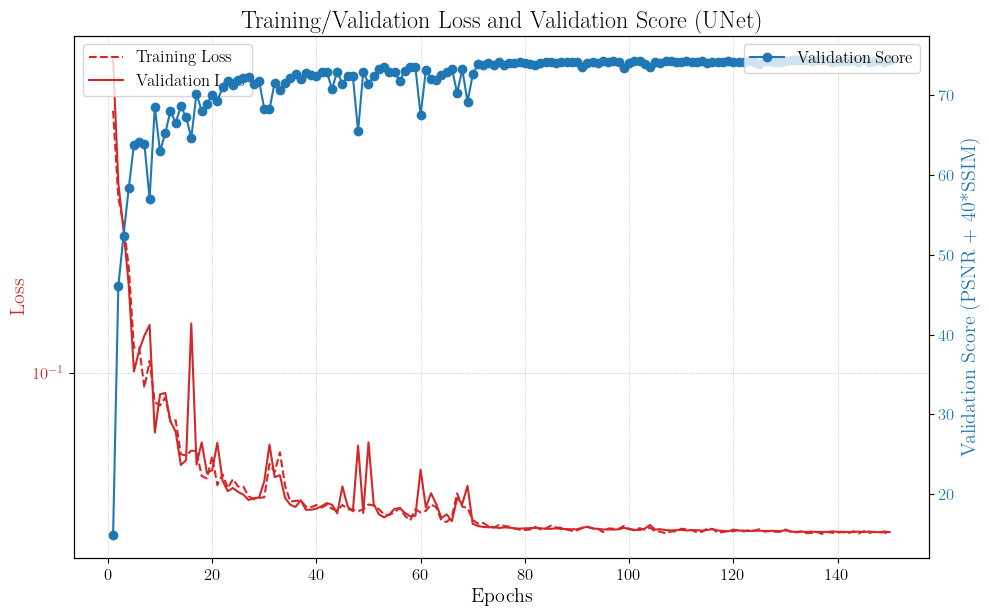


--- Initialization and Training Setup Complete ---


In [214]:
# TensorBoard Writer Setup
log_subdir = datetime.now().strftime('%Y%m%d-%H%M%S')
writer = SummaryWriter(log_dir=os.path.join(TENSORBOARD_LOG_DIR, log_subdir))
print(f"TensorBoard logs will be saved to: {os.path.join(TENSORBOARD_LOG_DIR, log_subdir)}")

# --- Instantiate Models ---
# Stage 1: EDSR-like Upsampler (128 -> 256)
sr_upsampler = EDSRUpsampler(
    n_resblocks=8,  # Number of residual blocks (tuneable)
    n_feats=64,     # Number of features (tuneable)
    scale=2,        # Upscale factor
    n_colors=1
).to(DEVICE)

# Stage 2: U-Net Refiner (256 -> 256) - Your existing UNet class configured for refinement
refinement_unet = UNet(
    n_channels=1, # Takes 1 channel input (output of sr_upsampler)
    n_classes=1,
    depth=UNET_DEPTH,
    start_filters=UNET_START_FILTERS, # Use configured UNet width
    bilinear=False
).to(DEVICE)

# --- Optimizer ---
# Combine parameters from both models for end-to-end training
all_params = list(sr_upsampler.parameters()) + list(refinement_unet.parameters())
optimizer = optim.AdamW(all_params, lr=LEARNING_RATE, weight_decay=1e-5) # Optimizer sees all parameters

# --- LR Scheduler ---
# Scheduler will monitor validation score and adjust LR for all parameters
scheduler = ReduceLROnPlateau(optimizer,
                              mode='max',
                              factor=SCHEDULER_FACTOR,
                              patience=SCHEDULER_PATIENCE,
                              threshold=SCHEDULER_THRESHOLD,
                              min_lr=SCHEDULER_MIN_LR,
                              verbose=True)

# --- Loss Function ---
criterion = CombinedLoss(alpha=LOSS_ALPHA, data_range=1.0).to(DEVICE)

# Updated call to train_model with separate save paths
train_model(
    sr_model=sr_upsampler,
    refine_model=refinement_unet,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    sr_save_path=SR_MODEL_SAVE_PATH,
    refine_save_path=REFINE_MODEL_SAVE_PATH,
    writer=writer
)

print("\n--- Initialization and Training Setup Complete ---")

### Evaluate the Best Model on a Validation Image Example


--- Evaluating Best Cascade Models on Example Validation Image ---
EDSRUpsampler initialized: n_resblocks=8, n_feats=64, scale=2
UNet initialized as Refinement Network: depth=3, start_filters=64, bilinear=False
Loaded best SR model weights from best_sr_upsampler_model.pth
Loaded best Refinement UNet model weights from best_refinement_unet_model.pth

Metrics for Example Image (Index 1):
  PSNR: 34.99 dB
  SSIM: 0.9527
  Score (PSNR + 40*SSIM): 73.0982


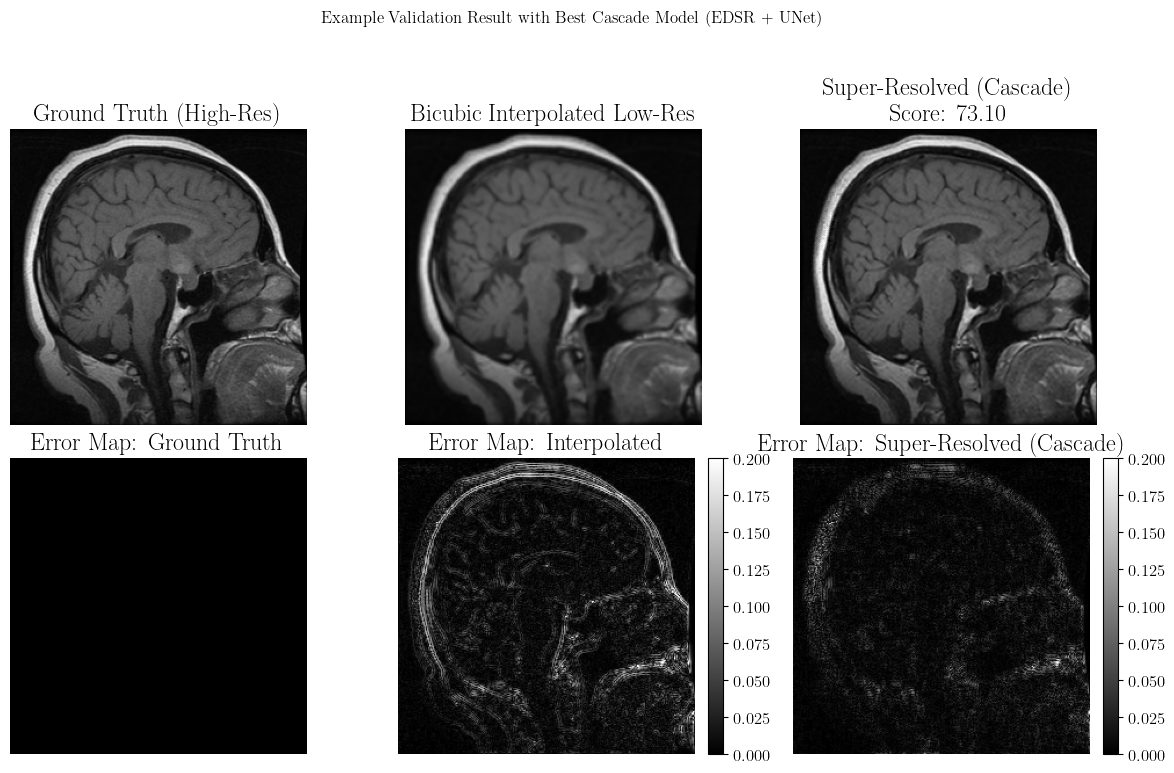

In [215]:
print("\n--- Evaluating Best Cascade Models on Example Validation Image ---")

# --- Instantiate and Load Best Models ---
# Instantiate both models
best_sr_model = EDSRUpsampler(
    n_resblocks=8, n_feats=64, scale=2, n_colors=1 # Use same params as training
).to(DEVICE)
best_refine_model = UNet(
    n_channels=1, n_classes=1, depth=UNET_DEPTH, start_filters=UNET_START_FILTERS # Use same params as training
).to(DEVICE)

# Load state dicts
try:
    best_sr_model.load_state_dict(torch.load(SR_MODEL_SAVE_PATH, map_location=DEVICE))
    best_refine_model.load_state_dict(torch.load(REFINE_MODEL_SAVE_PATH, map_location=DEVICE))
    best_sr_model.eval()
    best_refine_model.eval()
    print(f"Loaded best SR model weights from {SR_MODEL_SAVE_PATH}")
    print(f"Loaded best Refinement UNet model weights from {REFINE_MODEL_SAVE_PATH}")
    models_loaded = True
except FileNotFoundError:
    print(f"Error: One or both best model files not found ('{SR_MODEL_SAVE_PATH}', '{REFINE_MODEL_SAVE_PATH}'). Skipping example evaluation.")
    # Fallback: Try using models from end of training if available (might not be best)
    try:
        best_sr_model = sr_upsampler
        best_refine_model = refinement_unet
        best_sr_model.eval()
        best_refine_model.eval()
        print("Warning: Using models from end of training, not necessarily the best ones.")
        models_loaded = True # Treat as loaded for proceeding, but acknowledge fallback
    except NameError:
        models_loaded = False # Models not even available from training end
except Exception as e:
     print(f"Error loading model weights: {e}. Skipping example evaluation.")
     models_loaded = False


if models_loaded:
    # Load one validation image pair (using index 1 as example now)
    try:
        # Get sample directly using the dataset's __getitem__
        val_low_res, val_high_res = val_dataset[1] # Using index 1
        if val_low_res is None or val_high_res is None:
            raise ValueError("Failed to load validation sample 1.")

        val_low_res, val_high_res = val_low_res.to(DEVICE), val_high_res.to(DEVICE)

        # Prepare inputs (add batch dim)
        val_low_res_batch = val_low_res.unsqueeze(0) # Shape: [1, 1, 128, 128]
        val_high_res_batch = val_high_res.unsqueeze(0) # Shape: [1, 1, 256, 256]

        # --- Apply the best cascade models ---
        with torch.no_grad():
            initial_sr_output = best_sr_model(val_low_res_batch)      # Stage 1
            final_refined_output = best_refine_model(initial_sr_output) # Stage 2
            val_super_res_batch = final_refined_output # Use final output for metrics/vis

        # Calculate metrics for this example (using final output)
        ex_psnr, ex_ssim, ex_score = calculate_metrics(val_super_res_batch, val_high_res_batch)
        print(f"\nMetrics for Example Image (Index 1):") # Updated index
        print(f"  PSNR: {ex_psnr:.2f} dB" if ex_psnr != float('inf') else "  PSNR: inf dB")
        print(f"  SSIM: {ex_ssim:.4f}")
        print(f"  Score (PSNR + 40*SSIM): {ex_score:.4f}" if ex_score != float('inf') else "  Score: inf")

        # --- Visualization ---
        val_low_res_interpolated_vis = F.interpolate(val_low_res_batch, scale_factor=2, mode='bicubic', align_corners=False)

        # Convert tensors to numpy for visualization
        val_low_res_np_vis = val_low_res_interpolated_vis.squeeze().cpu().numpy()
        val_high_res_np = val_high_res_batch.squeeze().cpu().numpy()
        # Use the final output of the cascade for visualization
        val_super_res_np = torch.clamp(val_super_res_batch, 0.0, 1.0).squeeze().cpu().numpy()

        # Plotting (code remains the same, but uses cascade output)
        fig, ax = plt.subplots(2, 3, figsize=(12, 8))
        fig.suptitle("Example Validation Result with Best Cascade Model (EDSR + UNet)") # Updated title
        im_opts = {'cmap': 'gray', 'vmin': 0, 'vmax': 1}
        err_opts = {'cmap': 'gray', 'vmin': 0, 'vmax': 1/5}
        err_scale = 1

        ax[0, 0].imshow(val_high_res_np, **im_opts)
        ax[0, 0].set_title('Ground Truth (High-Res)')
        ax[0, 1].imshow(val_low_res_np_vis, **im_opts)
        ax[0, 1].set_title('Bicubic Interpolated Low-Res')
        ax[0, 2].imshow(val_super_res_np, **im_opts)
        ax[0, 2].set_title(f'Super-Resolved (Cascade)\nScore: {ex_score:.2f}' if ex_score != float('inf') else 'Super-Resolved (Cascade)\nScore: inf')

        err_gt_interp = np.abs(val_high_res_np - val_low_res_np_vis)
        err_gt_superres = np.abs(val_high_res_np - val_super_res_np)
        ax[1, 0].imshow(np.zeros_like(val_high_res_np), **err_opts)
        ax[1, 0].set_title('Error Map: Ground Truth')
        im1 = ax[1, 1].imshow(err_gt_interp, **err_opts)
        ax[1, 1].set_title(f'Error Map: Interpolated')
        fig.colorbar(im1, ax=ax[1, 1], fraction=0.046, pad=0.04)
        im2 = ax[1, 2].imshow(err_gt_superres, **err_opts)
        ax[1, 2].set_title(f'Error Map: Super-Resolved (Cascade)')
        fig.colorbar(im2, ax=ax[1, 2], fraction=0.046, pad=0.04)

        for r in range(2):
            for c in range(3):
                ax[r, c].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    except IndexError:
         print("Error: Not enough images in validation dataset to display example index 1.") # Updated index
    except Exception as e:
         print(f"An error occurred during example evaluation visualization: {e}")
         traceback.print_exc()
else:
    print("Skipping example evaluation as models could not be loaded.")

### Final Evaluation on Full Validation Set with Best Model

In [216]:
print("\n--- Evaluating Best Cascade Models on Full Validation Set ---")

# --- Instantiate and Load Best Models ---
# Instantiate both models
best_sr_model_final = EDSRUpsampler(
    n_resblocks=8, n_feats=64, scale=2, n_colors=1 # Use same params as training
).to(DEVICE)
best_refine_model_final = UNet(
    n_channels=1, n_classes=1, depth=UNET_DEPTH, start_filters=UNET_START_FILTERS # Use same params as training
).to(DEVICE)

models_loaded_final = False
try:
    best_sr_model_final.load_state_dict(torch.load(SR_MODEL_SAVE_PATH, map_location=DEVICE))
    best_refine_model_final.load_state_dict(torch.load(REFINE_MODEL_SAVE_PATH, map_location=DEVICE))
    best_sr_model_final.eval()
    best_refine_model_final.eval()
    print(f"Using best SR model weights from {SR_MODEL_SAVE_PATH} for final evaluation.")
    print(f"Using best Refinement UNet model weights from {REFINE_MODEL_SAVE_PATH} for final evaluation.")
    models_loaded_final = True
except Exception as e:
    print(f"Warning: Could not load best model states for final evaluation ({e}). Skipping final evaluation.")


if models_loaded_final:
    # Re-calculate criterion if needed
    final_criterion = CombinedLoss(alpha=LOSS_ALPHA, data_range=1.0).to(DEVICE)

    # --- Call validate_model with both loaded models ---
    final_val_loss, final_psnr, final_ssim, final_score = validate_model(
        best_sr_model_final,
        best_refine_model_final,
        val_loader,
        final_criterion
    )

    print(f"\nFinal Metrics using Best Cascade Models on Validation Set:")
    print(f"  Average PSNR: {final_psnr:.2f} dB" if final_psnr != float('inf') else "  Average PSNR: inf dB")
    print(f"  Average SSIM: {final_ssim:.4f}")
    print(f"  Average Score (PSNR + 40*SSIM): {final_score:.4f}" if final_score != float('inf') else "  Average Score: inf")
    print(f"  Average Validation Loss: {final_val_loss:.6f}")

    # Reference Interpolation Metrics (code remains the same)
    print("\nFor Reference (metrics for simple Bicubic Interpolation on Validation Set):")
    ref_psnr_total, ref_ssim_total, ref_score_total, ref_samples = 0.0, 0.0, 0.0, 0
    inf_score_ref_count = 0
    with torch.no_grad():
        for batch in val_loader:
            if batch is None or len(batch) != 2: continue
            low_res_batch_ref, high_res_batch_ref = batch
            if low_res_batch_ref is None or high_res_batch_ref is None: continue

            batch_size_ref = low_res_batch_ref.size(0)
            low_res_batch_ref, high_res_batch_ref = low_res_batch_ref.to(DEVICE), high_res_batch_ref.to(DEVICE)
            low_res_interpolated_ref = F.interpolate(low_res_batch_ref, scale_factor=2, mode='bicubic', align_corners=False)
            psnr_ref, ssim_ref, score_ref = calculate_metrics(low_res_interpolated_ref, high_res_batch_ref)

            if score_ref == float('inf'):
                inf_score_ref_count += batch_size_ref
                ref_samples += batch_size_ref # Count sample
            elif not (math.isnan(psnr_ref) or math.isnan(ssim_ref) or math.isnan(score_ref)):
                ref_psnr_total += psnr_ref * batch_size_ref
                ref_ssim_total += ssim_ref * batch_size_ref
                ref_score_total += score_ref * batch_size_ref
                ref_samples += batch_size_ref
            else:
                 print(f"Warning: NaN metric encountered in reference calculation.")


    if ref_samples > 0:
        valid_ref_samples = ref_samples - inf_score_ref_count
        if valid_ref_samples > 0:
            avg_ref_psnr = ref_psnr_total / valid_ref_samples
            avg_ref_ssim = ref_ssim_total / valid_ref_samples
            avg_ref_score = ref_score_total / valid_ref_samples
        elif inf_score_ref_count > 0: # All reference scores were inf
            avg_ref_psnr = float('inf')
            avg_ref_ssim = 1.0
            avg_ref_score = float('inf')
        else: # No valid samples at all
            avg_ref_psnr, avg_ref_ssim, avg_ref_score = 0.0, 0.0, 0.0

        print(f"  Interpolation Average PSNR: {avg_ref_psnr:.2f} dB" if avg_ref_psnr != float('inf') else "  Interpolation Average PSNR: inf dB")
        print(f"  Interpolation Average SSIM: {avg_ref_ssim:.4f}")
        print(f"  Interpolation Average Score: {avg_ref_score:.4f}" if avg_ref_score != float('inf') else "  Interpolation Average Score: inf")
    else:
        print("Could not calculate reference interpolation metrics (no valid samples).")

else:
    print("Best model not available for final evaluation.")

print("\n--- Script End ---")


--- Evaluating Best Cascade Models on Full Validation Set ---
EDSRUpsampler initialized: n_resblocks=8, n_feats=64, scale=2
UNet initialized as Refinement Network: depth=3, start_filters=64, bilinear=False
Using best SR model weights from best_sr_upsampler_model.pth for final evaluation.
Using best Refinement UNet model weights from best_refinement_unet_model.pth for final evaluation.
CombinedLoss initialized with alpha=0.85 (weight for 1-SSIM loss), beta=0.15000000000000002 (weight for Pixel loss)
Using L1Loss for pixel loss.

Final Metrics using Best Cascade Models on Validation Set:
  Average PSNR: 35.98 dB
  Average SSIM: 0.9613
  Average Score (PSNR + 40*SSIM): 74.4305
  Average Validation Loss: 0.034417

For Reference (metrics for simple Bicubic Interpolation on Validation Set):
  Interpolation Average PSNR: 31.09 dB
  Interpolation Average SSIM: 0.9073
  Interpolation Average Score: 67.3829

--- Script End ---
